# Data Analysis for project Olist
GitHub location: https://github.com/LarsTinnefeld/olist_ecom_analysis.git

Structure of this notebook:
- Data import and preparation
- Exploratory data analysis
- Extracting trends and predictions from the order data
- Find main contributors to customer satisfaction
- Create a regression model which can predict customer satisfaction based on conditions
- Investigate order- and SKU profile hint a potential for automation

---
# Importing libraries

In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import datetime
from datetime import datetime as dt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, classification_report

In [3]:
sns.set_style("whitegrid")

---
---
# Data import, checks and preparation
High level view of the content. Not all available data tables will be needed for the project, only:
- Order
- Order Items
- Order review
- Prodcuts

In [4]:
df_orders = pd.read_csv("olist_orders_dataset.csv")
df_order_items = pd.read_csv("olist_order_items_dataset.csv")
df_order_review = pd.read_csv("olist_order_reviews_dataset.csv")
df_products = pd.read_csv("olist_products_dataset.csv")

---
## Order data preparation
The order data table contains order IDs with time stamps and customer ID.

In [5]:
df_orders.describe().transpose()

,count,unique,top,freq
order_id,99441,99441,3124a5d54e93ba5ff18e0b1db8737f08,1
customer_id,99441,99441,e99e1e11fa176e28f882fc339aeba6d3,1
order_status,99441,8,delivered,96478
order_purchase_timestamp,99441,98875,2018-07-28 13:11:22,3
order_approved_at,99281,90733,2018-02-27 04:31:10,9
order_delivered_carrier_date,97658,81018,2018-05-09 15:48:00,47
order_delivered_customer_date,96476,95664,2017-06-19 18:47:51,3
order_estimated_delivery_date,99441,459,2017-12-20 00:00:00,522


In [6]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [7]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


A few missing data in the date fields. Date will need to be formated as datetime.

Important for our project are order purchase data and delivery date. We convert these two columns into datetime format:

In [8]:
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], format='%Y-%m-%d').dt.date

In [9]:
df_orders['order_estimated_delivery_date'] = pd.to_datetime(df_orders['order_estimated_delivery_date'], format='%Y-%m-%d').dt.date

Checking if there are repeating order-ids:

In [10]:
print('Total of unique orders: ', format(len(df_orders['order_id'].unique())))
print('Total of records: ', format(len(df_orders)))

Total of unique orders:  99441
Total of records:  99441


### Adding a new feature 'delivery_time', which contains the delivery duration from order to delivery. This might be a potential contributor to user satisfaction.

In [81]:
df_orders['delivery_time'] = (df_orders['order_estimated_delivery_date'] - df_orders['order_purchase_timestamp']).astype('timedelta64[D]')

checking delivery durations:

In [82]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99441 non-null  object 
 1   customer_id                    99441 non-null  object 
 2   order_status                   99441 non-null  object 
 3   order_purchase_timestamp       99441 non-null  object 
 4   order_approved_at              99281 non-null  object 
 5   order_delivered_carrier_date   97658 non-null  object 
 6   order_delivered_customer_date  96476 non-null  object 
 7   order_estimated_delivery_date  99441 non-null  object 
 8   delivery_time                  99441 non-null  float64
dtypes: float64(1), object(8)
memory usage: 6.8+ MB


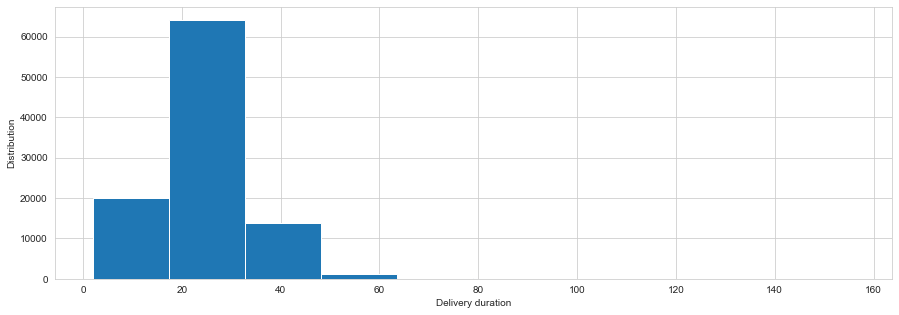

In [83]:
df_orders['delivery_time'].plot.hist(figsize=(15,5))
plt.ylabel('Distribution')
plt.xlabel('Delivery duration');

In [14]:
df_orders.describe()

,delivery_time
count,99441
mean,24 days 09:41:41.113222
std,8 days 19:54:34.774348
min,2 days 00:00:00
25%,19 days 00:00:00
50%,24 days 00:00:00
75%,29 days 00:00:00
max,156 days 00:00:00


The distribution is skewed to the right (long slim tail for long delievery durations).

----------
## Order_item data
The table contains the orders in detail with SKUs, seller and prices.

In [15]:
df_order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [16]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [17]:
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [18]:
print('Total of unique orders: ', format(len(df_order_items['order_id'].unique())))
print('Total of records: ', format(len(df_order_items)))
print('Mean order lines per order: ', format(len(df_order_items)/len(df_order_items['order_id'].unique())))

Total of unique orders:  98666
Total of records:  112650
Mean order lines per order:  1.1417306873695092


First impression about typical order size: typical e-commerce

In [19]:
print('Number of duplcated records: ', format(df_order_items.duplicated().sum()))

Number of duplcated records:  0


## Need to generate table with quantity field
'order_item_id' is a running order line feature. For example: If an product is ordered with quantity 2, there are two rows which only differ from each other in the 'order_item_id' field. Instead, we need a single row with quantity 2 for such case.

Consolidate table:

In [20]:
df_order_items_consolidated = df_order_items.groupby(by=['product_id','order_id']).agg({'order_item_id':'count', 'seller_id':'first', 'shipping_limit_date': 'first', 'shipping_limit_date': 'first', 'price': 'first', 'freight_value': 'first'}).reset_index()

In [21]:
print('Checking is no info was lost')
print('Orders in new table: ', format(len(df_order_items_consolidated['order_id'].unique())))
print('Orders in old table: ', format(len(df_order_items['order_id'].unique())))
print('SKUs in new table: ', format(len(df_order_items_consolidated['product_id'].unique())))
print('SKUs in old table: ', format(len(df_order_items['product_id'].unique())))
print('Total quantity in new table: ', format(df_order_items_consolidated['order_item_id'].sum()))
print('Total quantity in old table: ', format(len(df_order_items)))

Checking is no info was lost
Orders in new table:  98666
Orders in old table:  98666
SKUs in new table:  32951
SKUs in old table:  32951
Total quantity in new table:  112650
Total quantity in old table:  112650


### New order item table: 'df_order_items_consolidated'
No missing data. The order ID count is higher than in the order data which is would appear logic as oders will sometimes contain more than one order line. But in reality, there are more than 700 order IDs missing as the count of unique values shows.

---
## Creating combined order table
To create a order-volume-time series we will merge the order and the order-items data tables and group by days. The order-volume-time series will display how the order volume (orders, units sold, order lines, number of SKUs, number of customers) changed over time.

Tables to combine:
- df_orders
- df_order_items_consolidated

In [91]:
df_orders_merged = df_orders.merge(df_order_items_consolidated, on='order_id')

In [92]:
df_orders_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102425 entries, 0 to 102424
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       102425 non-null  object 
 1   customer_id                    102425 non-null  object 
 2   order_status                   102425 non-null  object 
 3   order_purchase_timestamp       102425 non-null  object 
 4   order_approved_at              102411 non-null  object 
 5   order_delivered_carrier_date   101397 non-null  object 
 6   order_delivered_customer_date  100195 non-null  object 
 7   order_estimated_delivery_date  102425 non-null  object 
 8   delivery_time                  102425 non-null  float64
 9   product_id                     102425 non-null  object 
 10  order_item_id                  102425 non-null  int64  
 11  seller_id                      102425 non-null  object 
 12  shipping_limit_date           

In [93]:
df_orders_merged.describe()

,delivery_time,order_item_id,price,freight_value
count,102425.000000,102425.000000,102425.000000,102425.000000
mean,24.452126,1.099829,124.422006,20.111152
std,8.848539,0.456926,188.926084,15.884700
min,3.000000,1.000000,0.850000,0.000000
25%,19.000000,1.000000,40.000000,13.140000
50%,24.000000,1.000000,78.800000,16.320000
75%,29.000000,1.000000,139.000000,21.220000
max,156.000000,20.000000,6735.000000,409.680000


In [94]:
df_orders_merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time,product_id,order_item_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,16.0,87285b34884572647811a353c7ac498a,1,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,20.0,595fac2a385ac33a80bd5114aec74eb8,1,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,27.0,aa4383b373c6aca5d8797843e5594415,1,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,27.0,d0b61bfb1de832b15ba9d266ca96e5b0,1,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,13.0,65266b2da20d04dbe00c5c2d3bb7859e,1,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


### Renaming columns, dropping not required columns:

In [95]:
df_orders_merged.rename(columns={'order_purchase_timestamp':'order_date', 'order_estimated_delivery_date': 'delivery_date', 'product_id': 'SKU_id', 'order_item_id': 'qty'}, inplace=True)

In [96]:
df_orders_merged.drop(['order_delivered_carrier_date', 'order_delivered_customer_date', 'order_approved_at', 'shipping_limit_date'], axis=1, inplace=True)

In [97]:
df_orders_merged.columns

Index(['order_id', 'customer_id', 'order_status', 'order_date',
       'delivery_date', 'delivery_time', 'SKU_id', 'qty', 'seller_id', 'price',
       'freight_value'],
      dtype='object')

---
## Order review data preparation
The order review data lists all reviews with assiciated order-id, mesage, timestamp and score. The 'score' feature will later be used to build a logistic regression or linear regression model.

In [29]:
df_order_review.describe()

,review_score
count,100000.000000
mean,4.070890
std,1.359663
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [30]:
df_order_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [31]:
df_order_review.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [32]:
print('Count of unique review-ids: ', format(len(df_order_review['review_id'].unique())))
print('Count of total reviews: ', format(len(df_order_review['review_id'])))
print('Count of unique order-ids: ', format(len(df_order_review['order_id'].unique())))

Count of unique review-ids:  99173
Count of total reviews:  100000
Count of unique order-ids:  99441


There 827 are more revies than review ids (0.8%). 99.7% of all orders have revies. => This is a very good representation.

<AxesSubplot:>

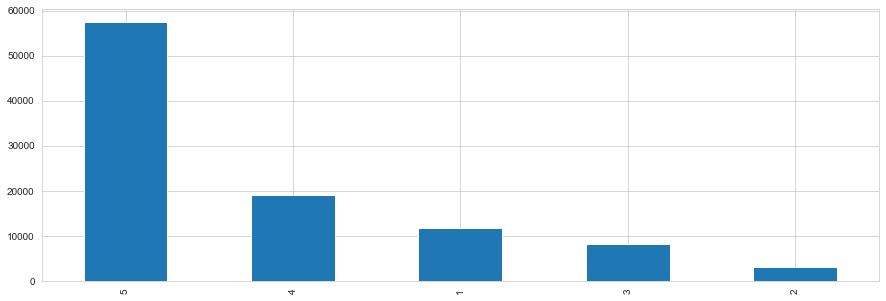

In [33]:
df_order_review['review_score'].value_counts().plot(kind='bar', figsize=(15,5))

In [34]:
df_order_review['review_score'].value_counts()/len(df_order_review)*100

5    57.420
4    19.200
1    11.858
3     8.287
2     3.235
Name: review_score, dtype: float64

The score ratings are unevenly distributed. More than 50% of all ratings have a score of 5. We need to see if this will impact the prediction model. It needs to be decided if we will use a linear regression model or a logistic regression model. Transforming the scores into dummy-categories (one-hot method) or keeping as numerical feature will therefore be decided later in the analysis phase.

---
## Products table preparation
The lookup table contains the products, their description and physical properties. Physical properties are one side of the filter process to review the business case from a technological angle of view.

In [35]:
df_products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [36]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [37]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [38]:
print('Checking duplicated entries:')
df_products['product_id'].duplicated().sum()

Checking duplicated entries:


0

---
### Following clean tables are now available for the exploratory analysis:
- df_orders_merged
- df_products
- df_order_review

still available:
- df_orders
- df_order_items

---
---
# Exploratory data analysis

## Order data
### Points of interest:
- Trend and pattern in order volumne over time
- Correlation order volume to delivery duration?
- Order profile (units per order)
- Order profile (units per order line)
- Order lines per order

### Taking a look at the physical product properties

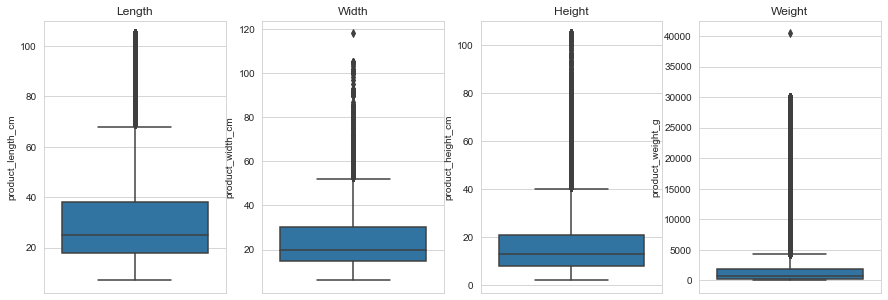

In [39]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,5))
ax1.set_title('Length')
ax2.set_title('Width')
ax3.set_title('Height')
ax4.set_title('Weight')

sns.boxplot(data=df_products, orient='v', x='product_length_cm', ax=ax1)
sns.boxplot(data=df_products, orient='v', x='product_width_cm', ax=ax2)
sns.boxplot(data=df_products, orient='v', x='product_height_cm', ax=ax3)
sns.boxplot(data=df_products, orient='v', x='product_weight_g', ax=ax4);

All product features show a right skewd distribution (long tail to the larger values). Generally, products seem in the suitable range for logistic autmation, but the exceptions will remain the observed outliers. We will take a closer look later.

### Checking order price distribution:

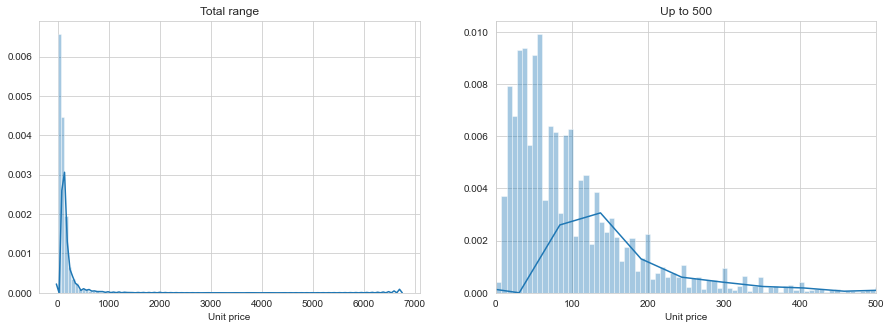

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.set_title('Total range')
ax2.set_title('Up to 500')

ax2.set_xlim([0, 500])

sns.distplot(df_orders_merged['price'], bins=100, ax=ax1, axlabel='Unit price',)
sns.distplot(df_orders_merged['price'], bins=1000, ax=ax2, axlabel='Unit price');

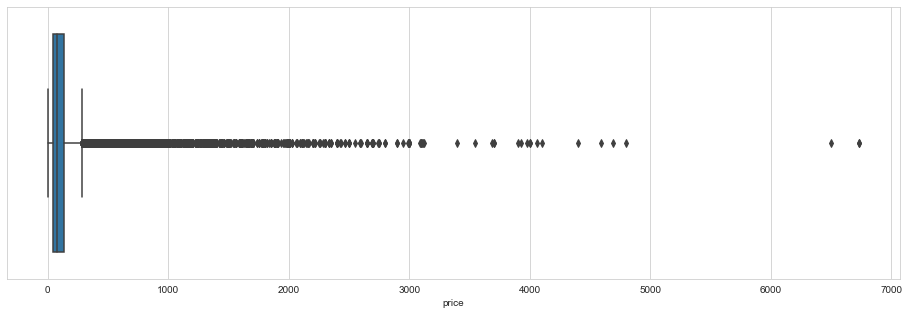

In [88]:
plt.figure(figsize=(16,5))
sns.boxplot(df_orders_merged['price']);

No currency was provided with the data set, but I assume this Brazilian Real. The statistical mean for the item price is 120, but this based on a skewed distribution. The majority of the prices is in the lower range of up to 100.

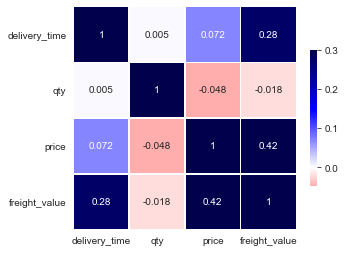

In [86]:
plt.figure(figsize=(5,5))
sns.heatmap(df_orders_merged.corr(), cmap='seismic_r', vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

There's little correlation within the numrical features of the order table.

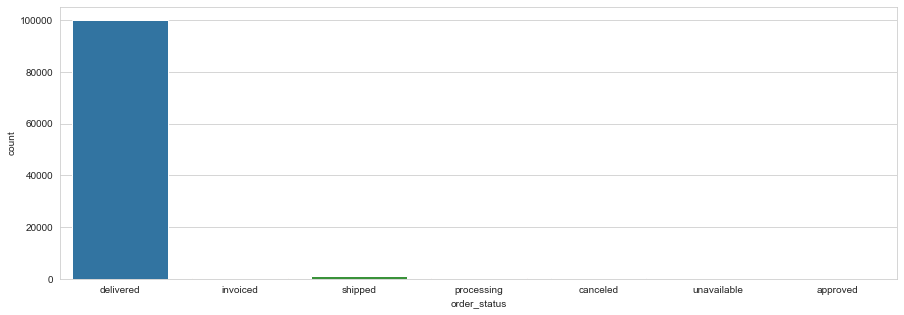

In [85]:
plt.figure(figsize=(15,5))
sns.countplot(df_orders_merged['order_status']);

In [44]:
df_orders_merged['order_status'].value_counts()/len(df_orders_merged)*100

delivered      97.823773
shipped         1.100317
canceled        0.453991
invoiced        0.314376
processing      0.298755
unavailable     0.006834
approved        0.001953
Name: order_status, dtype: float64

98% of all orders were delivered.

### Creating daily order table
This table summarizes features by day in order to have a base to extract trends and time series.

In [146]:
df_orders_daily = df_orders_merged.groupby('order_date').agg({'qty':'sum', 'order_id':'count', 'price':'sum', 'delivery_time': 'mean'})

In [147]:
df_orders_daily.rename(columns={'order_id': 'lines', 'delivery_time':'avg_delivery_time'}, inplace=True)
df_orders_daily.reset_index(inplace=True)
df_orders_daily.head()

,order_date,qty,lines,price,avg_delivery_time
0,2016-09-04,2,2,72.89,46.000
1,2016-09-05,1,1,59.50,53.000
2,2016-09-15,3,1,44.99,19.000
3,2016-10-02,1,1,100.00,23.000
4,2016-10-03,8,8,463.48,47.875


---
---
## Investigating business trends

First a review the business development over time.

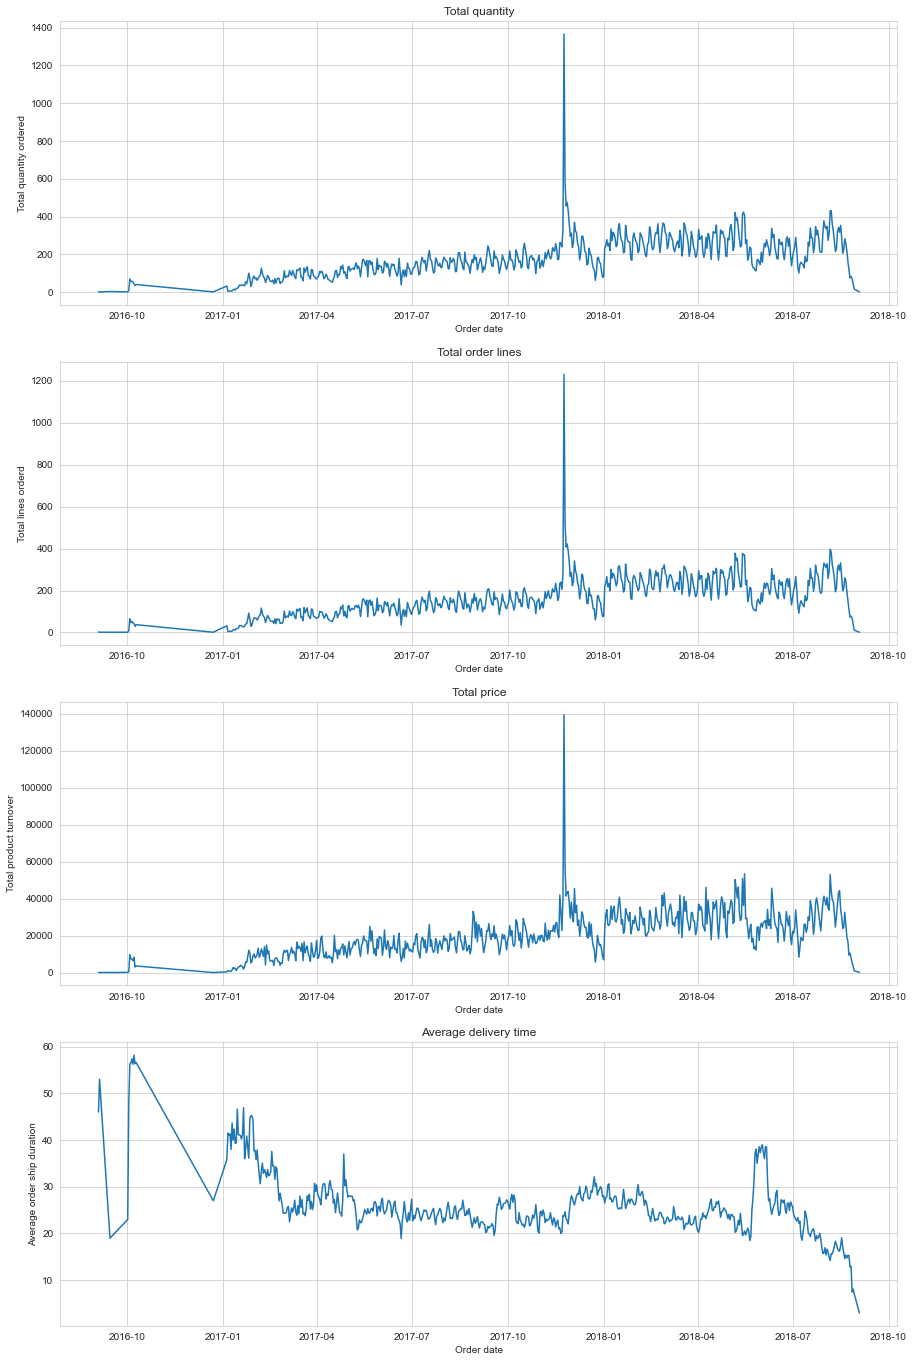

In [148]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,24))
ax1.set_title('Total quantity')
ax2.set_title('Total order lines')
ax3.set_title('Total price')
ax4.set_title('Average delivery time')

sns.lineplot(data=df_orders_daily, x='order_date',y='qty', ax=ax1)
sns.lineplot(data=df_orders_daily, x='order_date',y='lines', ax=ax2)
sns.lineplot(data=df_orders_daily, x='order_date',y='price', ax=ax3)
sns.lineplot(data=df_orders_daily, x='order_date',y='avg_delivery_time', ax=ax4)

ax1.set(xlabel='Order date', ylabel='Total quantity ordered')
ax2.set(xlabel='Order date', ylabel='Total lines orderd')
ax3.set(xlabel='Order date', ylabel='Total product turnover')
ax4.set(xlabel='Order date', ylabel='Average order ship duration');

Let's take a look when the big spike die appear:

In [223]:
df_orders_daily[df_orders_daily['qty']==df_orders_daily['qty'].max()]

,order_date,qty,lines,price,avg_delivery_time,date_ordinal
336,2017-11-24,1366,1231,139471.97,23.69212,736657


The time series charts show an upwards trend (increase of business activity). At the same time the shipping duration has a general downward trend. There is a heavy peak at Black Friday. Surprisingly, the average shipping duration was not impacted by this spike. A reason might be that the order handling was not managed centrally but directly from the shopkeepers. This must be considered in the evaluation of the potential business sevice extension.

There is a sudden steep increase in order shipment duration mid to end of June 2018. This falls in the time period of the FIFA World Cup, which happened in Brazil from June 18-27. It can't be confirmed that this is correlated, but would be plausible.

The trend can be visualized with a linear regression fit line. Seaborn's regplot requires to transform the date format into a float format, which can be done by applying ordinal.

In [216]:
df_orders_daily['date_ordinal'] = df_orders_daily['order_date'].apply(lambda date: date.toordinal())

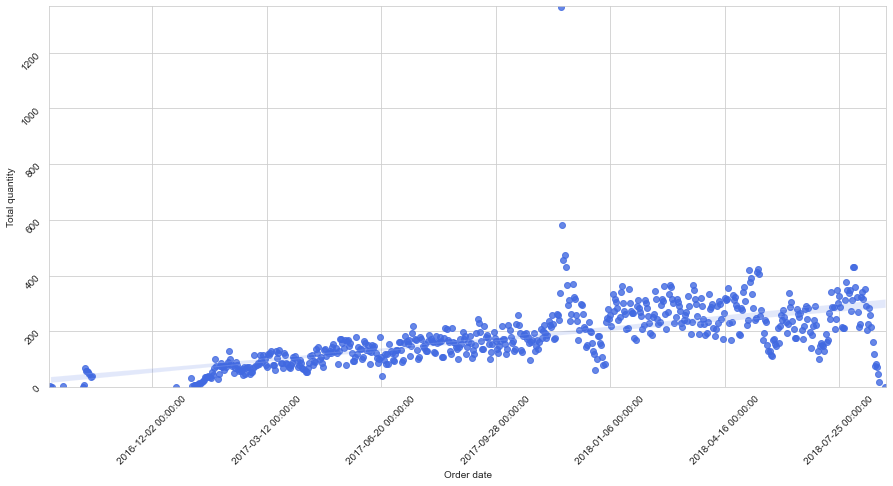

In [217]:
plt.figure(figsize=(15,7))
ax = sns.regplot(data=df_orders_daily,x='date_ordinal',y='qty', color='royalblue')

ax.set_xlim(df_orders_daily['date_ordinal'].min() - 1, df_orders_daily['date_ordinal'].max() + 1)
ax.set_ylim(0, df_orders_daily['qty'].max() + 1)

ax.set_xlabel('Order date')
ax.set_ylabel('Total quantity')
new_labels = [dt.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
ax.tick_params(labelrotation=45)

There is a clear upward trend in the business which can be seen in turnover and order volume.
Alsough the spike at Black Friday is typical for e-commerce businesses, the enormeous magnitude is a concern which needs to be addressed in the review of the logistic process.

### To generate a projection for the future business a linear regression modell will be applied.

Splitting the data into target feature (for simplicity we select quantity, but the process could be repeated for turnover and order lines) and the timeline. Normally, all remaining numerical features would represent the input values, but in this case all these values are linked and dependent on each other (more qty means more turnover and more order lines).

In [225]:
X = df_orders_daily['qty']
y = df_orders_daily['date_ordinal']

In [307]:
# Splitting into train- and test data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [327]:
# Setting up linear regresion model:
lm_model = LinearRegression(normalize=True)
# We don't need to normalize in this case, because we have only one input feature

In [328]:
# Because we have only one x-feature in a form of a 1Xm vector, we need to reshape it to mX1 before fitting it to the model
lm_model.fit(np.array(X_train).reshape(-1, 1), y_train)

LinearRegression(normalize=True)

Making predictions:

In [329]:
y_preditions_train = lm_model.predict(np.array(X_train).reshape(-1, 1))
y_preditions_test = lm_model.predict(np.array(X_test).reshape(-1, 1))

Validating the precision of the model with the r2-score:

In [330]:
print(r2_score(y_train, y_preditions_train))
print(r2_score(y_test, y_preditions_test))

0.399232042687248
0.5301311362346732


This looks like a pretty bad working model. Potentially, the data points have a too high variation which makes predictions uncertain. I tried with different training sized with the same outcome. That means the sizing of a potential future logistic process need to have enough flexibility to handle this variance.

---
## Customer satisfaction analysis